<a href="https://colab.research.google.com/github/jacobazevedojr/CECS-451-Assignment6/blob/Shujoy/minefinder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CECS 451 Assignment 6**

## **Minesweeper Agent**

-------------------------------------------------------------------------

Variables in Mines:

self.flags -- a list of tuples describing the position of discovered mines (row, col)

Usable Functions from Mines class:

checkcell() -- Checks whether a cell contains a mine or not, will trigger the mine (and lose the game) if one exists

showcurrent() -- Displays the current grid

isfail() -- returns true if a mine has exploded

checkmines() -- checks if self.flags is identical to the actual locations of mines



##**Description**

-------------------------------------------------------------------------

Each position on the board is either an open space or a mine. If the space is open it has a value corresponding to its position. This value describes how many mines are adjacent to the position (left-right, up-down, and diagonals). To win the game, you must logically deduce where the mines are (or where they aren't) to explore all squares and to "flag" all mines.

##**Algorithm**

-------------------------------------------------------------------------

(1) Generate an n x n grid with k mines (This assignment uses n = 16, k = 40)

(2) Always begin by exploring (0, 0), it is guaranteed to be safe

> Each square adjacent to (0, 0) should have a number corresponding to the number of surrounding mines. *Note in the below picture*

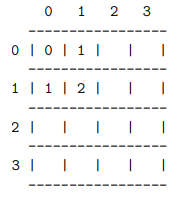

(3) Build a system of equations describing the current state of the board *Note in the below picture* The system of equations can be described as a set of logical statements with the + indicating an OR relationship. The value equaling the statement is a representation that allows us to see how many mines are tied to the statements.

> If len(statement) == value, all unexplored squares are GUARANTEED to be mines

> Otherwise, the system of equations must be "probed" to determine if safe spots exist

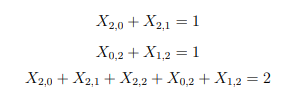

(4) Build a truth table with the current variables *Note in the below picture* (notice how it is not always efficient to build a system of equations with ALL values on the frontier). *Maybe we can expand locally** when I play, I typically do not account for the entire board, I break it up into a series of micropuzzles.

> Within the truth table, find ALL rows that satisfy the system of equations.

> Then, examine the columns. If any column is all 0's, it is GUARANTEED to be safe. Likewise, if any column is all 1's, it is GUARANTEED to be a mine and it can be flagged

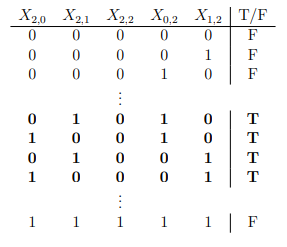

(5) Sometimes, there comes points where logical deduction shouldn't be possible. You're forced to make a guess. I'm not sure if Moon's board is guaranteed solvable, but if it isn't we need to account for situations where the machine has to "guess." If we represent positions with probabilities, we can give our machine the ability to choose the highest likelihood choices (or a shot in the dark in the case of 50-50s)


In [239]:
from mines import Mines

In [240]:
# (1) Build the Mines map

# Board dimensions
n = 4
# Number of mines
k = 3

board = Mines(n, k)

# (2) (0, 0) is already explored by default, and guaranteed to have a value of 0
# All squares adjacent to a 0 are explored by default

visited = [['-1' for i in range(n)] for i in range(n)]

# Display the board
board.showcurrent()

     0   1   2   3   
   -----------------
 0 | 0 | 0 | 1 |   |
   -----------------
 1 | 0 | 0 | 2 |   |
   -----------------
 2 | 0 | 0 | 2 |   |
   -----------------
 3 | 0 | 0 | 2 |   |
   -----------------



In [241]:
# Build the frontier, so we know which squares to examine 
# (eliminates the need to explored the entire nxn map more than once)
# INITIALIZATION METHOD (called once)

# Returns a list of tuples corresponding to each explored position that is 
# adjacent to at least ONE unexplored square

# We don't factor in mine locations yet, because this is ONLY used to initialize
# frontier locations

# Parameters: brd - mine board

# Returns: 
def buildFrontier(brd):
  pass

In [242]:
def updateFrontier(brd,frontier,location):
  pass

In [243]:
# Generates a system of equations for the current board state


# Parameters: brd -- mine board, frontier -- locations of explored squares along
# the unexplored boundary

# Returns: tuple (systemOfEquations, unexploredVariableSet, varMap) 
# (Feel free to shorten names)

# systemOfEquations -- list of tuples (Positions, squareValue)
# Positions -- List of unexplored positions adjacent to square on the frontier
# squareValue -- Value in the corresponding square on the frontier
# ^ e.g. systemOfEquations = [ ([(2,3), (2,2), (2,1)], 1), ... ([(2,0), (2,1), (2,2), (2,3)], 1) ]

# unexploredVariableSet -- A set of position tuples 
# These positions are the set of positions that are used in the system of eqs.
# Set has no duplicates

# (These positions will be used as propositions in the truth table)
# e.g ((2,3), (2,2), (2,1), (2,0), ...)

# varMap -- a dictionary mapping each position to a column
# e.g. ((1,2) : 0, (3,2): 1, ... (4,5) : n)

def generateEquations(brd, frontier, flags):
  
  frontier = [(0,1), (1,1), (2,1), (2,0)]

  grid = brd.checkcell((0,0))
  sysEqs = []
  # create dictionary varMap
  varMap = {}
  # create counter for sysEq column position 
  counter = 0

  validNeighbors = []

  # create set of flags to values

  # iterate through each location in frontier:
  for location in frontier:
    # check all 8 squares around the location

    # check the 3 rows at or surrounding current location
    for i in range(location[0] - 1, location[0] + 2):
      # check the 3 columns at or surrounding current location
      for j in range(location[1] - 1, location[1] + 2):

        # skip if square is it's the original location square or out of bounds
        if (i == 0 and j == 0) or (i < 0 or j < 0) or (i > n or j > n):
          continue
        # also skip if it's already discovered or flagged
        if grid[i][j] != ' ' or (i, j) in flags:
          continue

        # initialize array of tuples to store "neighbors" of location
        validNeighbors = []

          # add it to varMap and increment counter if not already in
        if (i, j) not in varMap:
          varMap[(i, j)] = counter
          counter += 1
        # add it to current list of valid neighbors
        validNeighbors.append((i, j))

    # add array of tuples and value of square to system of equations
    sysEqs.append((validNeighbors, int(grid[location[0]][location[1]])))

  return (sysEqs, varMap)


In [244]:
import itertools


def truthTableSolve(sysEQs, varMap):
  validStates = []
  n = len(varMap)

  table = list(itertools.product([0, 1], repeat=n))

  for row in table:
    # Check for rows that satisfy the system of equations
    if satisfiesEQs(row, sysEQs, varMap) == True:
      validStates.append(row)
  
  # Check for columns of 1's or 0's. Track the best guess while none are found
  toCheck, mineLocs, bestGuess = columnCheck(validStates, varMap)

  return (toCheck, mineLocs, bestGuess)

In [245]:
def satisfiesEQs(row, sysEQs, varMap):
  # eq has form: [(2,3), (2,2), (2,1)], 1)
  # eq[0] = [(2,3), (2,2), (2,1)]
  # eq[1] = 1

  for eq in sysEQs:
    total = eq[1]
    for pos in eq[0]:
      # varMap[pos] returns the column index
      index = varMap[pos]
      # row[index] will have a 0 or 1
      total += row[index]
    # total must == eq[1] to be satisfactory
    if total != eq[1]:
      return False
  
  # Once the row has passed all equations, it is has been verified that it
  # satisfies the system or equations
  return True

In [246]:
def columnCheck(states, varMap):
  toCheck = []
  mineLocs = []
  bestGuess = None

  # Flag to specify that we should still be keeping track of the best guess
  noneFound = True

  min = float('inf')

  # This loop checks every column one by one for all 0's
  # or all 1's (or if nothing has been found yet, our bestGuess)
  for val, pos in enumerate(varMap):
    Score = 0
    allZeroes = True
    allOnes = True
    for row in states:
      if row[val] == 0:
        allOnes = False
      else:
        allZeroes = False
        # Higher score is worse (higher prob of being mine)
        Score += 1

      # If we have already found a move
      # And if all states aren't zeroes or ones exclusively
      # We don't need to explore the column any further
      # (Don't care about the best move right now)
      if noneFound == False and allOnes == False and allZeroes == False:
        continue
      
      # Otherwise, we continue the loop to track the best score so far

    # Tracks the best guess so far
    if Score < min and noneFound == True:
      min = Score
      bestGuess = pos
    else:
      if allZeroes == True:
        toCheck.append(pos)
      elif allOnes == True:
        mineLocs = []
      
  if len(toCheck) > 0 or len(minLocs) > 0:
    bestGuess = None

  return (toCheck, mineLocs, bestGuess)

In [247]:
# Driver to solve the minesweeper board

# Parameters: brd -- mine board
def solve(brd):
  # Frontier contains all explored positions that are adjacent to at least one
  # unexplored position (only if that position is NOT definitively a mine)
  frontier = buildFrontier(brd)
  flags = set(brd.flags)

  # While we haven't lost and the game hasn't been won
  while brd.isfail() == False and brd.checkmines() == False:
    # Utilizing the current board, generate a system of equations for every
    # position on the frontier

    # Function will also build a set of all variables to include within a truth
    # table
    # We should optimize and make sure that new equations aren't generated every
    # single time, maybe we can just call this once and just update going forward

    # A visited graph can help us determine if a position is 
    # (-1) not discovered (1) a mine or (0) safe
    # From there we can use the logic to allow for previous equations to remain
    # unchanged (even when we discover new squares)
    sysEqs, varMap = generateEquations(brd, frontier, flags)
    # ^ variables is a set of all unexplored positions for the TT

    # Solve the system of equations with a truth table. Returns the next moves
    # to take and the locations of the discovered mines (add to flags)

    # While toCheck is empty, bestGuess is tracked to determine the highest
    # probability choice
    toCheck, mineLocations, bestGuess = truthTableSolve(sysEqs, varMap);

    # Appends each tuple (row, col) from mineLocations into flags
    for location in mineLocations:
      flags.add(location)
      brd.flag.append(location)

    # Expands every location within the toCheck list
    for location in toCheck:
      brd.checkcell(location)
      # Expand frontier to reflect the new expansion 
      # all revealed squares ADJACENT to location are in the previous
      # frontier, they may or may not be in the frontier once location is 
      # revealed
      updateFrontier(brd, frontier, location)
    
    # No new expansions have been found, we must choose a 50-50
    # Choose the next expansion with the highest probability of being safe
    # Tally up the columns for each variable, the variable
    # with the lowest score is the safest (lowest number of states)
    if toCheck is None:
      brd.checkcell(bestGuess)

  if brd.isfail() == True:
    # We have lost
    return False
  
  # We have solved the board game
  return True

In [248]:
winFlag = solve(board)

if winFlag == True:
  board.showcurrent()
else:
  print("Solution failed")

NameError: ignored